### Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

# Create a directory for saving models if it doesn't exist
if not os.path.exists('../models'):
    os.makedirs('../models')

# Load the data
df = pd.read_csv('../data/student_data_realistic.csv')

# Display the first few rows
df.head()

,student_id,student_name,course_code,term,credits,has_prerequisites,midterm_score,final_score,assignment_score,total_score,passed,attendance_rate
0,20260000,Sandra Hernandez,HU 323,Fall 2023,3,False,20,28,10,58,True,42.76
1,20260000,Sandra Hernandez,HU 331,Fall 2023,2,False,30,34,4,68,True,76.87
2,20260000,Sandra Hernandez,IS 333,Fall 2024,3,True,19,43,13,75,True,67.98
3,20260000,Sandra Hernandez,IS 498,Spring 2024,4,True,23,21,8,52,True,74.86
4,20260000,Sandra Hernandez,MA 111,Spring 2024,3,True,15,39,13,67,True,53.01


### Data Preprocessing


In [2]:
# Convert 'passed' to numeric if it's string (True/False)
if df['passed'].dtype == 'object':
    df['passed'] = df['passed'].map({'True': 1, 'False': 0})

# Check the data types and summary statistics
df.info()
df.describe()

# Check the distribution of pass/fail
print(f"Pass rate: {df['passed'].mean():.2%}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14995 entries, 0 to 14994
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   student_id         14995 non-null  int64  
 1   student_name       14995 non-null  object 
 2   course_code        14995 non-null  object 
 3   term               14995 non-null  object 
 4   credits            14995 non-null  int64  
 5   has_prerequisites  14995 non-null  bool   
 6   midterm_score      14995 non-null  int64  
 7   final_score        14995 non-null  int64  
 8   assignment_score   14995 non-null  int64  
 9   total_score        14995 non-null  int64  
 10  passed             14995 non-null  bool   
 11  attendance_rate    14995 non-null  float64
dtypes: bool(2), float64(1), int64(6), object(3)
memory usage: 1.2+ MB
Pass rate: 75.79%


### Train-Test Split

In [3]:
# Split into training and testing sets using a random split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['passed'])

print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")
print(f"Training set pass rate: {train_df['passed'].mean():.2%}")
print(f"Test set pass rate: {test_df['passed'].mean():.2%}")

Training set size: 11996
Test set size: 2999
Training set pass rate: 75.79%
Test set pass rate: 75.79%


### Feature Engineering

In [4]:
def create_features(student_df):
    """
    Create features for prediction based on student history.
    
    Parameters:
    -----------
    student_df : DataFrame
        DataFrame containing student course records
        
    Returns:
    --------
    DataFrame
        DataFrame of engineered features
    """
    # Student's historical performance features
    student_features = []
    
    for student_id in student_df['student_id'].unique():
        # Get student's past courses
        student_data = student_df[student_df['student_id'] == student_id]
        
        for idx, course in student_data.iterrows():
            # Features for this student-course combination
            features = {
                'student_id': student_id,
                'course_code': course['course_code'],
                'term': course['term'],
                'has_prerequisites': 1 if course['has_prerequisites'] else 0,
                'credits': course['credits'],
                'attendance_rate': course['attendance_rate'],
                'midterm_score': course['midterm_score'],
                'final_score': course['final_score'],
                'assignment_score': course['assignment_score'],
                'target_passed': 1 if course['passed'] else 0
            }
            
            # Get historical data for this student (excluding current course)
            past_courses = student_df[(student_df['student_id'] == student_id) & 
                                     (student_df.index != idx)]
            
            if len(past_courses) > 0:
                features.update({
                    'past_avg_total_score': past_courses['total_score'].mean(),
                    'past_avg_midterm_score': past_courses['midterm_score'].mean(),
                    'past_avg_final_score': past_courses['final_score'].mean(),
                    'past_avg_assignment_score': past_courses['assignment_score'].mean(),
                    'past_avg_attendance': past_courses['attendance_rate'].mean(),
                    'past_pass_rate': past_courses['passed'].mean(),
                    'courses_taken': len(past_courses)
                })
                
                # Calculate pass rate for similar courses (same department)
                dept = course['course_code'].split()[0]  # Get department (e.g., 'CS', 'IS')
                similar_courses = past_courses[past_courses['course_code'].str.startswith(dept)]
                if len(similar_courses) > 0:
                    features['dept_pass_rate'] = similar_courses['passed'].mean()
                else:
                    features['dept_pass_rate'] = features['past_pass_rate']
                    
                # Add feature for prerequisite performance if applicable
                if course['has_prerequisites']:
                    prereq_courses = past_courses[past_courses['has_prerequisites']]
                    if len(prereq_courses) > 0:
                        features['prereq_avg_score'] = prereq_courses['total_score'].mean()
                        features['prereq_pass_rate'] = prereq_courses['passed'].mean()
                    else:
                        features['prereq_avg_score'] = features['past_avg_total_score']
                        features['prereq_pass_rate'] = features['past_pass_rate']
                else:
                    features['prereq_avg_score'] = 0
                    features['prereq_pass_rate'] = 0
            else:
                # No historical data, use defaults
                features.update({
                    'past_avg_total_score': 0,
                    'past_avg_midterm_score': 0, 
                    'past_avg_final_score': 0,
                    'past_avg_assignment_score': 0,
                    'past_avg_attendance': 0,
                    'past_pass_rate': 0,
                    'courses_taken': 0,
                    'dept_pass_rate': 0,
                    'prereq_avg_score': 0,
                    'prereq_pass_rate': 0
                })
                
            student_features.append(features)
    
    return pd.DataFrame(student_features)

# Create feature dataframes
print("Creating training features...")
train_features = create_features(train_df)
print("Creating testing features...")
test_features = create_features(test_df)

# Save the feature dataframes for future use
train_features.to_csv('../models/train_features.csv', index=False)
test_features.to_csv('../models/test_features.csv', index=False)

# Display a sample of the features
train_features.head()

Creating training features...
Creating testing features...


,student_id,course_code,term,has_prerequisites,credits,attendance_rate,midterm_score,final_score,assignment_score,target_passed,past_avg_total_score,past_avg_midterm_score,past_avg_final_score,past_avg_assignment_score,past_avg_attendance,past_pass_rate,courses_taken,dept_pass_rate,prereq_avg_score,prereq_pass_rate
0,20261037,CS 112,Fall 2023,1,2,88.99,21,27,14,1,52.2,17.0,24.0,11.2,71.682,0.6,5,1.0,59.75,0.75
1,20261037,HU 112,Spring 2024,1,2,97.71,26,25,16,1,51.2,16.0,24.4,10.8,69.938,0.6,5,0.0,58.50,0.75
2,20261037,IS 211,Spring 2024,1,2,74.83,20,22,16,1,53.0,17.2,25.0,10.8,74.514,0.6,5,0.0,60.75,0.75
3,20261037,IS 365,Spring 2024,1,2,41.92,12,26,10,0,55.0,18.8,24.2,12.0,81.096,0.8,5,1.0,63.25,1.00
4,20261037,HU 334,Fall 2023,0,4,68.66,2,19,1,0,60.2,20.8,25.6,13.8,75.748,0.8,5,1.0,0.00,0.00


### Model Training - Random Forest

In [5]:
# Define features and target
features = [
    'has_prerequisites', 'credits', 'attendance_rate', 
    'midterm_score', 'final_score', 'assignment_score',
    'past_avg_total_score', 'past_avg_midterm_score', 'past_avg_final_score',
    'past_avg_assignment_score', 'past_avg_attendance', 'past_pass_rate',
    'courses_taken', 'dept_pass_rate', 'prereq_avg_score', 'prereq_pass_rate'
]

X_train = train_features[features]
y_train = train_features['target_passed']
X_test = test_features[features]
y_test = test_features['target_passed']

# Save feature lists for future reference
with open('../models/feature_list.txt', 'w') as f:
    for feature in features:
        f.write(f"{feature}\n")

# Train a Random Forest model
print("Training Random Forest model...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Save the model
with open('../models/random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
print("Random Forest model saved to '../models/random_forest_model.pkl'")

# Make predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)[:,1]

# Evaluate model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"\nRandom Forest Accuracy: {accuracy_rf:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

Training Random Forest model...
Random Forest model saved to '../models/random_forest_model.pkl'

Random Forest Accuracy: 0.9266

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.82      0.84       726
           1       0.94      0.96      0.95      2273

    accuracy                           0.93      2999
   macro avg       0.91      0.89      0.90      2999
weighted avg       0.93      0.93      0.93      2999



### Model Visualization - Random Forest


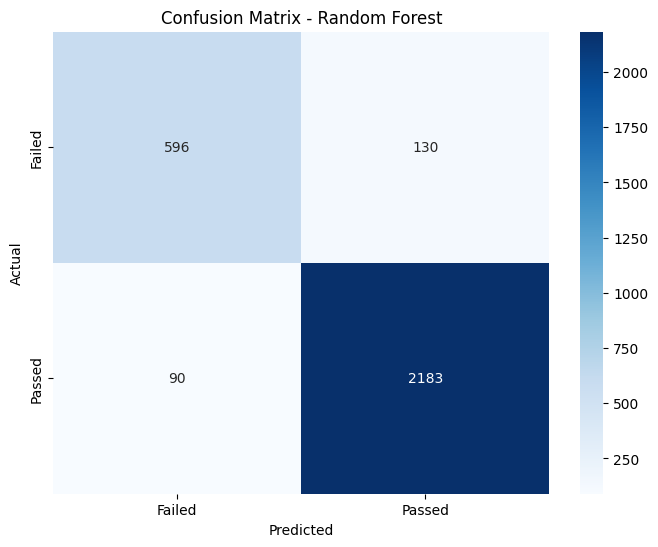

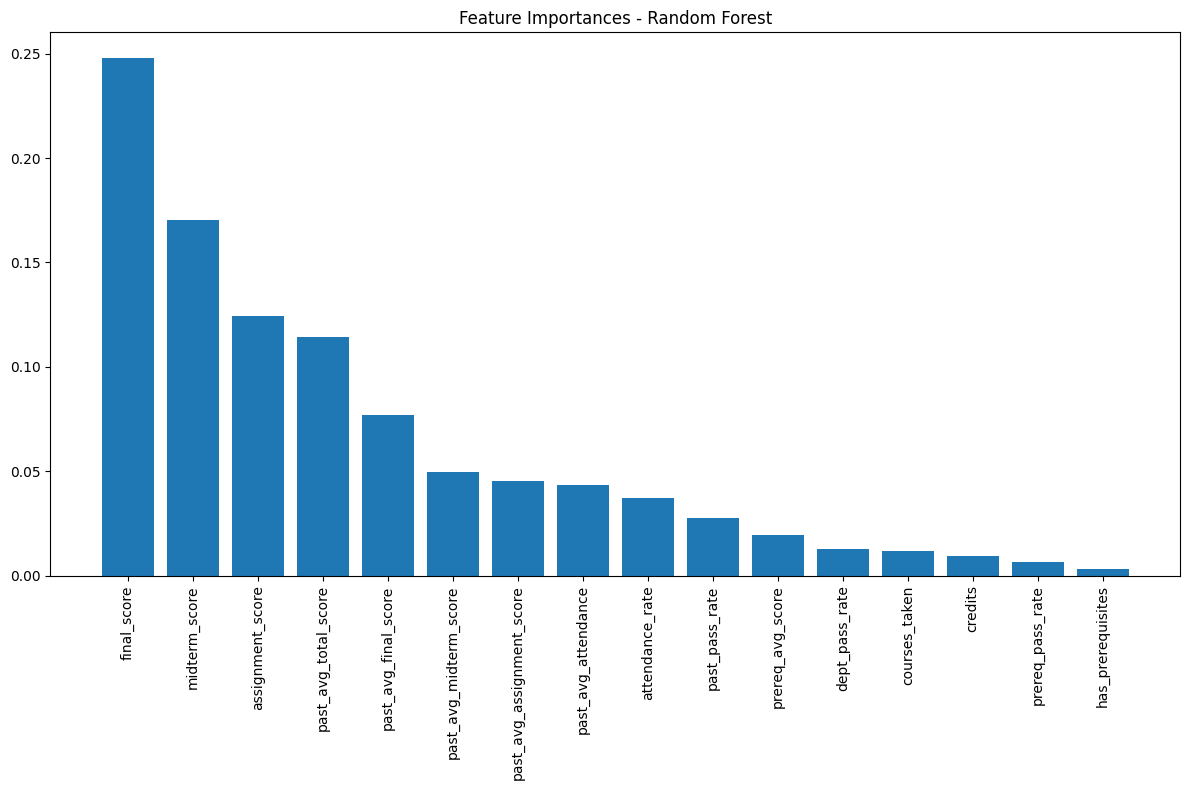

In [6]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Failed', 'Passed'],
            yticklabels=['Failed', 'Passed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.savefig('../models/confusion_matrix_rf.png')
plt.show()

# Plot feature importance
plt.figure(figsize=(12, 8))
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=90)
plt.title('Feature Importances - Random Forest')
plt.tight_layout()
plt.savefig('../models/feature_importance_rf.png')
plt.show()

### Model Training - Gradient Boosting


In [7]:
# Train a Gradient Boosting model for comparison
print("Training Gradient Boosting model...")
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Save the GB model
with open('../models/gradient_boosting_model.pkl', 'wb') as f:
    pickle.dump(gb_model, f)
print("Gradient Boosting model saved to '../models/gradient_boosting_model.pkl'")

# Evaluate GB model
y_pred_gb = gb_model.predict(X_test)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"\nGradient Boosting Accuracy: {accuracy_gb:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb))

Training Gradient Boosting model...
Gradient Boosting model saved to '../models/gradient_boosting_model.pkl'

Gradient Boosting Accuracy: 0.9030

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.82      0.80       726
           1       0.94      0.93      0.94      2273

    accuracy                           0.90      2999
   macro avg       0.86      0.87      0.87      2999
weighted avg       0.90      0.90      0.90      2999



### Model Visualization - Gradient Boosting


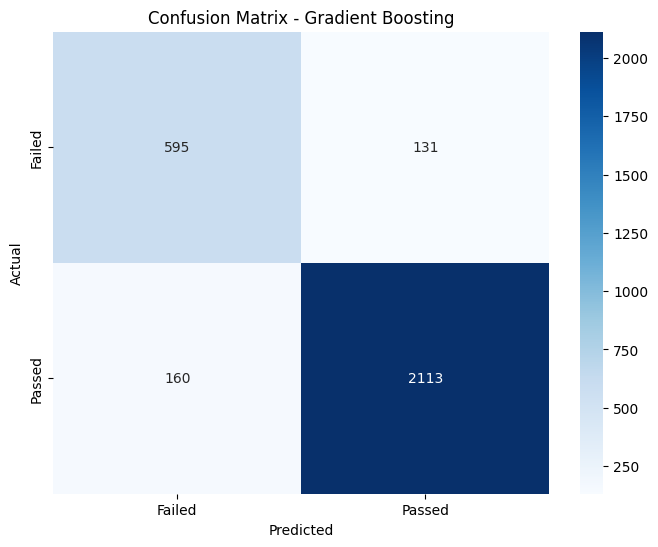

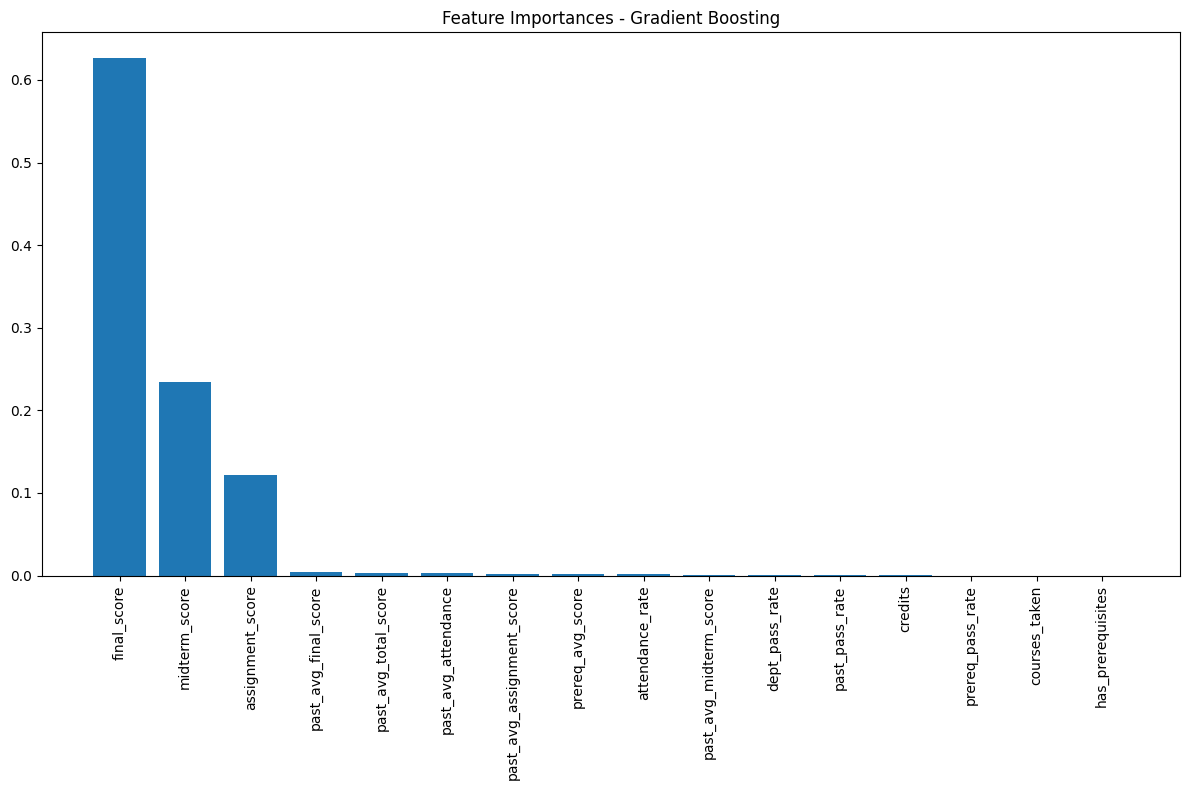

In [8]:
# Plot confusion matrix for GB
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_gb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Failed', 'Passed'],
            yticklabels=['Failed', 'Passed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Gradient Boosting')
plt.savefig('../models/confusion_matrix_gb.png')
plt.show()

# Plot feature importance for GB
plt.figure(figsize=(12, 8))
importances = gb_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=90)
plt.title('Feature Importances - Gradient Boosting')
plt.tight_layout()
plt.savefig('../models/feature_importance_gb.png')
plt.show()

### Prediction Function for New Courses

In [9]:
def predict_course_outcome(model, student_id, course_code, prereq, credits, 
                          attendance, midterm=None, final=None, assignment=None):
    """
    Predict if a student will pass a course based on their history and current course data.
    
    Parameters:
    -----------
    model : trained model object
        The trained model to use for prediction
    student_id : int
        ID of the student
    course_code : str
        Code of the course
    prereq : bool
        Whether the course has prerequisites
    credits : int
        Number of credits for the course
    attendance : float
        Expected attendance rate
    midterm, final, assignment : float, optional
        Current scores if available, otherwise predicted from history
        
    Returns:
    --------
    dict
        Dictionary containing prediction results and used features
    """
    # Get student history from the dataset
    student_history = df[df['student_id'] == student_id]
    
    if len(student_history) == 0:
        print(f"No history found for student {student_id}")
        # Use dataset averages
        past_features = {
            'past_avg_total_score': df['total_score'].mean(),
            'past_avg_midterm_score': df['midterm_score'].mean(),
            'past_avg_final_score': df['final_score'].mean(),
            'past_avg_assignment_score': df['assignment_score'].mean(),
            'past_avg_attendance': df['attendance_rate'].mean(),
            'past_pass_rate': df['passed'].mean(),
            'courses_taken': 0,
            'dept_pass_rate': df[df['course_code'].str.startswith(course_code.split()[0])]['passed'].mean(),
            'prereq_avg_score': df['total_score'].mean(),
            'prereq_pass_rate': df['passed'].mean()
        }
    else:
        # Calculate past performance metrics
        dept = course_code.split()[0]  # Get department code (e.g., 'CS', 'IS')
        similar_courses = student_history[student_history['course_code'].str.startswith(dept)]
        prereq_courses = student_history[student_history['has_prerequisites']]
        
        past_features = {
            'past_avg_total_score': student_history['total_score'].mean(),
            'past_avg_midterm_score': student_history['midterm_score'].mean(),
            'past_avg_final_score': student_history['final_score'].mean(),
            'past_avg_assignment_score': student_history['assignment_score'].mean(),
            'past_avg_attendance': student_history['attendance_rate'].mean(),
            'past_pass_rate': student_history['passed'].mean(),
            'courses_taken': len(student_history),
            'dept_pass_rate': similar_courses['passed'].mean() if len(similar_courses) > 0 else student_history['passed'].mean(),
            'prereq_avg_score': prereq_courses['total_score'].mean() if len(prereq_courses) > 0 else student_history['total_score'].mean(),
            'prereq_pass_rate': prereq_courses['passed'].mean() if len(prereq_courses) > 0 else student_history['passed'].mean()
        }
    
    # If scores aren't provided, estimate them from student history
    if midterm is None:
        midterm = past_features['past_avg_midterm_score']
    if final is None:
        final = past_features['past_avg_final_score']
    if assignment is None:
        assignment = past_features['past_avg_assignment_score']
    
    # Create prediction data
    pred_data = {
        'has_prerequisites': 1 if prereq else 0,
        'credits': credits,
        'attendance_rate': attendance,
        'midterm_score': midterm,
        'final_score': final,
        'assignment_score': assignment,
    }
    pred_data.update(past_features)
    
    # Convert to DataFrame with only the features used in the model
    pred_df = pd.DataFrame([pred_data])
    
    # Make prediction
    probability = model.predict_proba(pred_df[features])[0, 1]
    predicted = model.predict(pred_df[features])[0]
    
    return {
        'student_id': student_id,
        'course_code': course_code,
        'predicted_pass': bool(predicted),
        'pass_probability': probability,
        'features_used': pred_data
    }

In [10]:
# Example 1: Predict with actual scores
prediction1 = predict_course_outcome(
    model=rf_model, 
    student_id=20261000,
    course_code="IS 499", 
    prereq=True,
    credits=3,
    attendance=85.0,
    midterm=25,
    final=40,
    assignment=15
)

# Example 2: Predict with no scores (will use student history)
prediction2 = predict_course_outcome(
    model=rf_model, 
    student_id=20261101,
    course_code="CS 450", 
    prereq=True,
    credits=3,
    attendance=75.0
)

# Print predictions
print("\nPrediction Example 1:")
print(f"Student {prediction1['student_id']} taking {prediction1['course_code']}:")
print(f"Pass prediction: {prediction1['predicted_pass']}")
print(f"Pass probability: {prediction1['pass_probability']:.2f}")

print("\nPrediction Example 2:")
print(f"Student {prediction2['student_id']} taking {prediction2['course_code']}:")
print(f"Pass prediction: {prediction2['predicted_pass']}")
print(f"Pass probability: {prediction2['pass_probability']:.2f}")

# Create a function to predict outcomes for multiple new courses
def batch_predict(model, new_courses_df):
    """
    Predict outcomes for multiple courses
    
    Parameters:
    -----------
    model : trained model
        Trained model to use for predictions
    new_courses_df : DataFrame
        DataFrame with columns: student_id, course_code, has_prerequisites,
        credits, attendance_rate, [midterm_score, final_score, assignment_score]
    
    Returns:
    --------
    DataFrame
        DataFrame with predictions
    """
    predictions = []
    
    for _, row in new_courses_df.iterrows():
        pred = predict_course_outcome(
            model=model,
            student_id=row['student_id'],
            course_code=row['course_code'],
            prereq=bool(row['has_prerequisites']),
            credits=row['credits'],
            attendance=row['attendance_rate'],
            midterm=row.get('midterm_score', None),
            final=row.get('final_score', None),
            assignment=row.get('assignment_score', None)
        )
        
        predictions.append({
            'student_id': row['student_id'],
            'course_code': row['course_code'],
            'predicted_pass': pred['predicted_pass'],
            'pass_probability': pred['pass_probability']
        })
    
    return pd.DataFrame(predictions)

# Example of batch prediction
# Create a sample dataframe with new courses
new_courses = pd.DataFrame([
    {
        'student_id': 20261000,
        'course_code': 'IS 499',
        'has_prerequisites': True,
        'credits': 3,
        'attendance_rate': 85.0
    },
    {
        'student_id': 20261101,
        'course_code': 'CS 450',
        'has_prerequisites': True,
        'credits': 3,
        'attendance_rate': 75.0
    },
    {
        'student_id': 20261102,
        'course_code': 'IS 443',
        'has_prerequisites': False,
        'credits': 3,
        'attendance_rate': 90.0,
        'midterm_score': 28,
        'final_score': 45,
        'assignment_score': 18
    }
])

# Get predictions for the batch
batch_results = batch_predict(rf_model, new_courses)
print("\nBatch Prediction Results:")
print(batch_results)

# Save the batch prediction results
batch_results.to_csv('../models/batch_predictions.csv', index=False)


Prediction Example 1:
Student 20261000 taking IS 499:
Pass prediction: True
Pass probability: 0.97

Prediction Example 2:
Student 20261101 taking CS 450:
Pass prediction: True
Pass probability: 0.90

Batch Prediction Results:
   student_id course_code  predicted_pass  pass_probability
0    20261000      IS 499            True              0.96
1    20261101      CS 450            True              0.95
2    20261102      IS 443            True              0.94


In [11]:
# احسبي عدد المواد اللي الطالب نجح فيها
fail_counts = df[df['passed'] == False].groupby('student_id').size()

# خدي الطلاب اللي سقطوا في أكتر من نص موادهم
student_total_courses = df.groupby('student_id').size()
# Align indices before comparison
weak_students_ids = fail_counts[fail_counts > (student_total_courses.reindex(fail_counts.index) * 0.5)].index

# طلع بيانات الطلاب الوحشين
weak_students_df = df[df['student_id'].isin(weak_students_ids)]

# عرض أول شوية منهم
print(weak_students_df.head())

    student_id    student_name course_code         term  credits  \
25    20260004  William Waters      CS 221    Fall 2023        4   
26    20260004  William Waters      HU 323    Fall 2023        3   
27    20260004  William Waters      CS 352    Fall 2024        4   
28    20260004  William Waters      IS 351    Fall 2024        4   
29    20260004  William Waters      IS 421  Spring 2024        4   

    has_prerequisites  midterm_score  final_score  assignment_score  \
25               True              8           11                 5   
26               True             16           19                10   
27              False              7           13                 0   
28              False             13            0                11   
29               True             14           10                 7   

    total_score  passed  attendance_rate  
25           24   False            78.82  
26           45   False            51.26  
27           20   False            